<a href="https://colab.research.google.com/github/VishwanthReddy99/DeepLearning-Projects/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian


# Hello

In [4]:
!pip install jovian --upgrade --quiet

In [5]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=338773485de5021bdc25dbb5bfb3b8b97c1508acae3835fae18bae7ea988cea2
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [6]:
!pip install opendatasets

In [7]:
import opendatasets as od

In [8]:
url="https://www.kaggle.com/omkargurav/face-mask-dataset"


In [9]:
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: v170399
Your Kaggle Key: ··········


  4%|▍         | 7.00M/163M [00:00<00:02, 68.6MB/s]

100%|██████████| 163M/163M [00:02<00:00, 78.8MB/s]


In [10]:
#Importing the libraries
import os
import torchvision
from torchvision.datasets import ImageFolder
from pathlib import Path
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import GPUtil

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [11]:
data_dir = Path("./face-mask-dataset/data")
labels = os.listdir(data_dir)
labels = ['with_mask', 'without_mask']
labels

['with_mask', 'without_mask']

In [12]:
# def conv_jpeg():
for folder in os.listdir(data_dir):
    for img in os.listdir(data_dir/folder):
        print(img)

Streaming output truncated to the last 5000 lines.
with_mask_1718.jpg
with_mask_1832.jpg
with_mask_584.jpg
with_mask_3280.jpg
with_mask_3021.jpg
with_mask_118.jpg
with_mask_3049.jpg
with_mask_50.jpg
with_mask_492.jpg
with_mask_965.jpg
with_mask_1168.jpg
with_mask_456.jpg
with_mask_1594.jpg
with_mask_3725.jpg
with_mask_1706.jpg
with_mask_595.jpg
with_mask_3231.jpg
with_mask_1996.jpg
with_mask_3603.jpg
with_mask_3076.jpg
with_mask_2980.jpg
with_mask_2819.jpg
with_mask_3372.jpg
with_mask_3418.jpg
with_mask_922.jpg
with_mask_1786.jpg
with_mask_3563.jpg
with_mask_466.jpg
with_mask_1374.jpg
with_mask_1482.jpg
with_mask_948.jpg
with_mask_1866.jpg
with_mask_1884.jpg
with_mask_3689.jpg
with_mask_3207.jpg
with_mask_1588.jpg
with_mask_287.jpg
with_mask_2107.jpg
with_mask_2755.jpg
with_mask_2531.jpg
with_mask_3586.jpg
with_mask_2451.jpg
with_mask_3114.jpg
with_mask_147.jpg
with_mask_1688.jpg
with_mask_1045.jpg
with_mask_2511.jpg
with_mask_2925.jpg
with_mask_751.jpg
with_mask_1088.jpg
with_mask_705

### Load the images and apply some transforms

Normalisation was not done because it results in worse accuracy compared to not doing it.

In [13]:
# Load dataset and apply some transforms

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats),
    ]
))

print(len(dataset), dataset.class_to_idx)

7553 {'with_mask': 0, 'without_mask': 1}


Checking out random images from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: with_mask


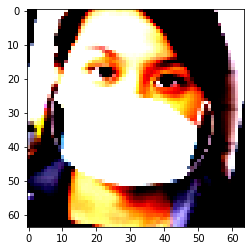

In [14]:
img, label = dataset[888]
plt.imshow(img.permute(1, 2, 0))
print(f"Label: {labels[label]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: with_mask


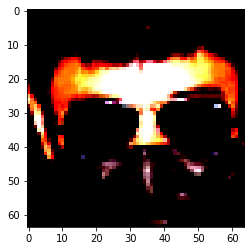

In [15]:
img, label = dataset[250]
plt.imshow(img.permute((1,2,0)))
print(f"Label: {labels[label]}")

In [16]:
# Set size of train_ds and val_ds

val_pct = 0.2
val_size = int(val_pct*len(dataset))
train_size = len(dataset)-val_size
train_size, val_size

(6043, 1510)

In [17]:
# Split dataset
train_ds, valid_ds = random_split(dataset,[train_size,val_size])

In [18]:
batch_size = 200

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)


torch.Size([200, 3, 64, 64])
tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1])


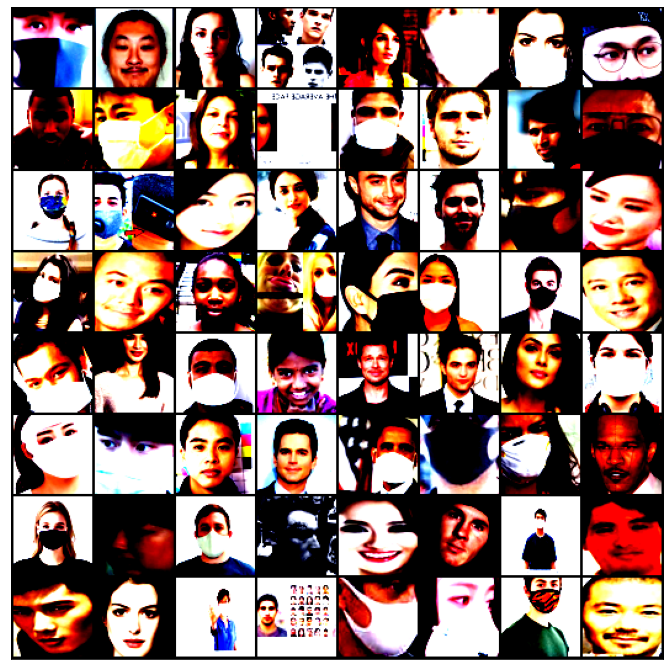

In [19]:
def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        print(labels)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda', index=0)

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

print(len(train_dl))
print(len(valid_dl))

31
4


In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions

        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512,1024)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        self.conv6 = conv_block(1024,2048, pool=True)
        self.res4 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))

        self.flat = nn.Flatten()
        self.drop = nn.Dropout(0.2)
        self.linear = nn.Linear(2048*4*4, 2)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out=self.conv5(out)
        out=self.res3(out) + out
        
        out=self.conv6(out)
        out=self.res4(out) + out

        out = self.flat(out)
        out = self.drop(out)
        out = self.linear(out)
        return out

In [25]:
model = to_device(ResNet9(3, 2), device)
GPUtil.showUtilization()
# model

| ID | GPU | MEM |
------------------
|  0 | 21% |  9% |


In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
        GPUtil.showUtilization()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
history = [evaluate(model, valid_dl)]
GPUtil.showUtilization()
history


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 56% |


[{'val_acc': 0.4148387014865875, 'val_loss': 0.6939808130264282}]

In [28]:
torch.cuda.empty_cache()

In [29]:
epochs = 20
max_lr = 0.03
grad_clip = 0.3
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU | MEM |
------------------
|  0 | 99% | 53% |
Epoch [0], last_lr: 0.00303, train_loss: 5.9719, val_loss: 83.6312, val_acc: 0.6274


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU | MEM |
------------------
|  0 | 99% | 70% |
Epoch [1], last_lr: 0.00826, train_loss: 2.2571, val_loss: 8.5154, val_acc: 0.6985


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [2], last_lr: 0.01548, train_loss: 2.7487, val_loss: 201.4653, val_acc: 0.4991


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [3], last_lr: 0.02273, train_loss: 3.6880, val_loss: 10.0066, val_acc: 0.5385


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [4], last_lr: 0.02805, train_loss: 4.0133, val_loss: 1.3102, val_acc: 0.7447


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [5], last_lr: 0.03000, train_loss: 1.5213, val_loss: 3.3756, val_acc: 0.4691


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [6], last_lr: 0.02962, train_loss: 1.2063, val_loss: 0.4058, val_acc: 0.8107


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [7], last_lr: 0.02851, train_loss: 1.4409, val_loss: 1.1299, val_acc: 0.8211


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [8], last_lr: 0.02673, train_loss: 0.7281, val_loss: 38.5907, val_acc: 0.5052


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU | MEM |
------------------
|  0 | 99% | 70% |
Epoch [9], last_lr: 0.02435, train_loss: 0.5424, val_loss: 2.2838, val_acc: 0.8319


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [10], last_lr: 0.02151, train_loss: 0.5886, val_loss: 0.9347, val_acc: 0.6776


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [11], last_lr: 0.01834, train_loss: 0.3188, val_loss: 1.4028, val_acc: 0.5282


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [12], last_lr: 0.01500, train_loss: 0.3571, val_loss: 0.2713, val_acc: 0.8952


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [13], last_lr: 0.01166, train_loss: 0.2507, val_loss: 0.2582, val_acc: 0.8968


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [14], last_lr: 0.00849, train_loss: 0.2626, val_loss: 0.4257, val_acc: 0.8986


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [15], last_lr: 0.00565, train_loss: 0.2136, val_loss: 0.1724, val_acc: 0.9334


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [16], last_lr: 0.00327, train_loss: 0.1649, val_loss: 0.1562, val_acc: 0.9433


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU | MEM |
------------------
|  0 | 99% | 70% |
Epoch [17], last_lr: 0.00149, train_loss: 0.1622, val_loss: 0.3600, val_acc: 0.9353


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU  | MEM |
-------------------
|  0 | 100% | 70% |
Epoch [18], last_lr: 0.00038, train_loss: 0.1529, val_loss: 0.1856, val_acc: 0.9478


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


| ID | GPU | MEM |
------------------
|  0 | 99% | 70% |
Epoch [19], last_lr: 0.00000, train_loss: 0.1497, val_loss: 0.2105, val_acc: 0.9515
CPU times: user 2min 18s, sys: 2min 33s, total: 4min 52s
Wall time: 10min 18s


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

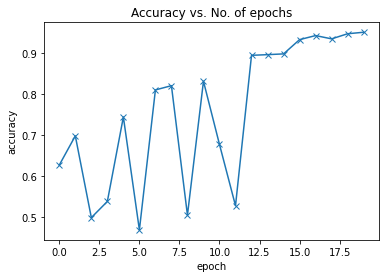

In [32]:
plot_accuracies(history)

In [33]:
test_data_link = "https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset"

In [34]:
od.download(test_data_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: v170399
Your Kaggle Key: ··········


  3%|▎         | 9.00M/330M [00:00<00:03, 87.8MB/s]

100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


In [35]:
td = './face-mask-12k-images-dataset/Face Mask Dataset/Train'
os.listdir(td)

['WithMask', 'WithoutMask']

In [36]:
test_data = ImageFolder(data_dir, tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats),
    ]
))

In [37]:
test_loader = DeviceDataLoader(DataLoader(test_data, batch_size=batch_size*2), device)

In [38]:
result = evaluate(model,test_loader)
result

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


{'val_acc': 0.9532812833786011, 'val_loss': 0.13936544954776764}

In [66]:
torch.save(model.state_dict(), 'maskdetection.pth')


In [40]:
jovian.log_hyperparams(arch='FaceDetection', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [44]:
jovian.log_metrics(test_acc=result['val_acc'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   )

[jovian] Metrics logged.


Maybe I can train now on the other dataset to improve the accuracy.

In [46]:
data_dir = Path("./face-mask-12k-images-dataset/Face Mask Dataset/Train")
labels = os.listdir(data_dir)
labels
# labels = ['with_mask', 'without_mask']
# labels

['WithMask', 'WithoutMask']

In [47]:
for folder in os.listdir(data_dir):
    for img in os.listdir(data_dir/folder):
        print(img)

Streaming output truncated to the last 5000 lines.
1529.png
5921.png
4486.png
1787.png
4983.png
1763.png
3869.png
3693.png
4413.png
4641.png
694.png
2698.png
3565.png
2846.png
3664.png
4316.png
4733.png
5199.png
2257.png
29.png
2426.png
5531.png
2432.png
1621.png
254.png
4956.png
4343.png
2756.png
2365.png
3149.png
4713.png
5465.png
3452.png
5829.png
3885.png
5034.png
3208.png
653.png
4473.png
2222.png
1352.png
4711.png
5432.png
170.png
3458.png
4242.png
1105.png
3881.png
252.png
303.png
445.png
3499.png
442.png
669.png
4165.png
1390.png
5146.png
547.png
3998.png
2189.png
2690.png
675.png
3569.png
3457.png
181.png
314.png
2362.png
2488.png
5126.png
3325.png
1505.png
2558.png
274.png
5915.png
4007.png
287.png
2170.png
4881.png
2269.png
5631.png
1697.png
4020.png
1240.png
1910.png
895.png
5564.png
20.png
5193.png
5456.png
2011.png
1008.png
5987.png
2775.png
4066.png
4735.png
1265.png
5726.png
3975.png
5512.png
2918.png
383.png
5999.png
1860.png
109.png
1346.png
4917.png
1129.png
1577.png

In [48]:
# Load dataset and apply some transforms
        
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats),
    ]
))

print(len(dataset), dataset.class_to_idx)

10000 {'WithMask': 0, 'WithoutMask': 1}


In [49]:
# Set size of train_ds and val_ds
val_pct = 0.2
val_size = int(val_pct*len(dataset))
train_size = len(dataset)-val_size
print(train_size, val_size)

# Split dataset
train_ds, valid_ds = random_split(dataset,[train_size,val_size])

batch_size = 200

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)

8000 2000


torch.Size([200, 3, 64, 64])
tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1])


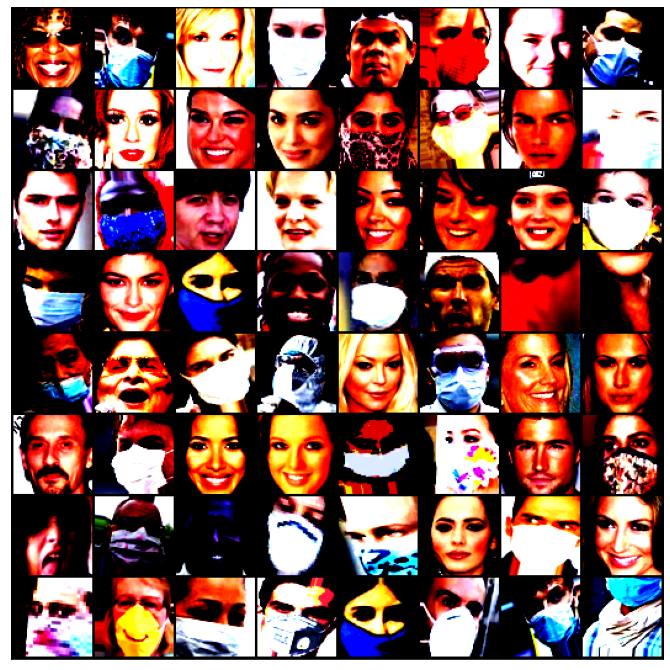

In [50]:
def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        print(labels)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

In [51]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

print(len(train_dl))
print(len(valid_dl))

40
5


In [52]:
%%time

epochs = 5
max_lr = 0.007
grad_clip = 0.3
weight_decay = 1e-5
opt_func = torch.optim.Adam


history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
Epoch [0], last_lr: 0.00527, train_loss: 0.2160, val_loss: 169.3268, val_acc: 0.7615
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |
Epoch [1], last_lr: 0.00665, train_loss: 0.1942, val_loss: 0.2341, val_acc: 0.9110
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |
Epoch [2], last_lr: 0.00428, train_loss: 0.4073, val_loss: 270.3952, val_acc: 0.7860
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |
Epoch [3], last_lr: 0.00132, train_loss: 0.1283, val_loss: 0.1363, val_acc: 0.9455
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 79% |
Epoch [4], last_lr: 0.00000, train_loss: 0.1037, val_loss: 0.1255, val_acc: 0.9515
CPU times: user 1min 8s, sys: 1min 19s, total: 2min 28s
Wall time: 2min 51s


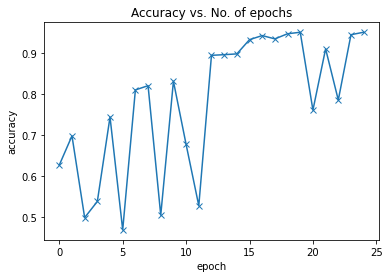

In [53]:
plot_accuracies(history)

## Testing the cross trained model.
Now I need to test it. I have not used the new dataset's validation images. Lets test on that.

In [54]:
td = './face-mask-12k-images-dataset/Face Mask Dataset/Validation'
print(os.listdir(td))

test_data = ImageFolder(td, tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats),
    ]
))

print("Total:", len(test_data), ", Classes to index:", dataset.class_to_idx)

test_loader = DeviceDataLoader(DataLoader(test_data, batch_size=batch_size*2), device)
result = evaluate(model,test_loader)
result


['WithMask', 'WithoutMask']
Total: 800 , Classes to index: {'WithMask': 0, 'WithoutMask': 1}


{'val_acc': 0.971250057220459, 'val_loss': 0.10340950638055801}

In [70]:
jovian.commit

<function jovian.utils.commit.commit>

In [73]:
!pip install jovian --upgrade --quiet

In [72]:
torch.save(model.state_dict(), 'maskdetection.pth')

jovian.log_hyperparams(arch='maskdetection', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

jovian.log_metrics(test_acc=result['val_acc'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   )
jovian.set_project('maskdetection')
jovian.set_colab_id('1P3GPjjtv96UcKDLMu_WD21QJ4w2JfLSH')
jovian.commit(project_name="maskdetection", outputs=[''])

[jovian] Hyperparams logged.
[jovian] Metrics logged.
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


[jovian] Capturing environment..
[jovian] Uploading additional outputs...


[jovian] Error: Ignoring "" (not found)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/vishwanthreddy99/maskdetection


'https://jovian.ai/vishwanthreddy99/maskdetection'